In [1]:
# TASK 1: POS Tagger Implementation (from scratch)
# Importing Required Libraries

import nltk
from nltk.corpus import treebank
from collections import defaultdict
import numpy as np

# Downloading the required corpus
nltk.download('treebank')

# Loading and Preparing Data
tagged_sentences = treebank.tagged_sents()  # Load sentences with all 45 POS tags used in the Penn Treebank

print(f"Total number of sentences is {len(tagged_sentences)}")

[nltk_data] Downloading package treebank to /usr/share/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
Total number of sentences is 3914


In [2]:
# Calculating the Emission and Transition Probabilities required for the Viterbi algorithm.

# The number of times each word has occured for each tag (emission counts)
emission_counts = defaultdict(lambda: defaultdict(int))

# The number of times each tag has appeared after every tag (transition counts)
transition_counts = defaultdict(lambda: defaultdict(int))

# The occurrences of each tag (tag counts)
tag_counts = defaultdict(int)

for sentence in tagged_sentences:
        prev_tag = '<START>'                            # <START> is set as the default previous tag
        for word, tag in sentence:
            emission_counts[tag][word] += 1                           
            transition_counts[prev_tag][tag] += 1       
            tag_counts[tag] += 1                            
            prev_tag = tag                              # Update the previous tag
        transition_counts[prev_tag]['<END>'] += 1       # For tags which have their next tag as <END>
        
emission_probs = defaultdict(lambda: defaultdict(float))
transition_probs = defaultdict(lambda: defaultdict(float))

for tag in tag_counts:
        for word in emission_counts[tag]:
            # emission probability = count(tag, word) / count(tag)
            emission_probs[tag][word] = emission_counts[tag][word] / tag_counts[tag]   
        for next_tag in transition_counts[tag]:
            # transition probability = count(tag, next_tag) / count(tag)
            transition_probs[tag][next_tag] = transition_counts[tag][next_tag] / tag_counts[tag]    
            
unique_tags = list(tag_counts.keys())                       
print(f"Total number of unique POS tags is {len(unique_tags)}")

Total number of unique POS tags is 46


In [3]:
# Implementing the Viterbi Algorithm to predict POS tags for a given sentence using dynamic programming

def viterbi_alg(sentence, tags, transition_probs, emission_probs):
    V = [{}]
    path = {}   

    # Initializing base cases (t = 0) 
    for tag in tags:
        # Probability of the first word being of a particular tag, if not present, use a small value
        V[0][tag] = transition_probs['<START>'].get(tag, 1e-8) * emission_probs[tag].get(sentence[0], 1e-8)  
        path[tag] = [tag]          # Initialize the path with the tag itself

    # Running the algorithm for the rest of the words
    for t in range(1, len(sentence)):
        V.append({})        # Add a new column for the next word       
        newpath = {}          

        for tag in tags:
            # Find the best previous tag
            (prob, state) = max((V[t-1][y] * transition_probs[y].get(tag, 1e-8) * emission_probs[tag].get(sentence[t], 1e-8), y) for y in tags)
            V[t][tag] = prob
            # Update the temporary path
            newpath[tag] = path[state] + [tag]

        path = newpath    # Update the final path

    # Find the best path
    (prob, state) = max((V[len(sentence) - 1][y], y) for y in tags)
    return path[state]

# Example sentence
sentence = ["The", "boy", "went", "up", "the", "stairs"]
predicted_tags = viterbi_alg(sentence, unique_tags, transition_probs, emission_probs)  # Passing the unique tags here 
print(f"Given sentence: {sentence}")
print(f"Predicted POS Tags for the sentence: {predicted_tags}")

Given sentence: ['The', 'boy', 'went', 'up', 'the', 'stairs']
Predicted POS Tags for the sentence: ['DT', 'NN', 'VBD', 'RP', 'DT', 'NNS']


In [4]:
# TASK 2: Vanilla Emotion Recognizer
# Install and Import Required Libraries
# Libraries for Task 2 and Task 3
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for Task 3
from sklearn.model_selection import GridSearchCV    # For Hyperparameter Tuning
from sklearn.pipeline import Pipeline, FeatureUnion               # For pipelining
from scipy.sparse import hstack, vstack             # To concatenate the sparse matrices
from sklearn.base import BaseEstimator, TransformerMixin


# Fetching twitter_messages dataset from Hugging Face and storing the splits as train, validation, and test datasets

dataset = load_dataset("dair-ai/emotion", "split")

training_dataset = dataset['train']
validation_dataset = dataset['validation']
testing_dataset = dataset['test']

X_training = training_dataset['text']
y_training = training_dataset['label']

X_validation = validation_dataset['text']
y_validation = validation_dataset['label']

X_testing = testing_dataset['text']
y_testing = testing_dataset['label']

print(f"Training dataset size is {len(X_training)}")
print(f"Validation dataset size is {len(X_validation)}")
print(f"Testing dataset size is {len(X_testing)}")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Training dataset size is 16000
Validation dataset size is 2000
Testing dataset size is 2000


In [5]:
# Hyperparameter tuning for SVM model without POS tags
# Defining the parameter grid for GridSearchCV
parameter_grid_1 = {
     'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],             # Maximum number of features to consider
     'svm__C': [0.1, 1, 10, 100]                                 # Regularization parameter
}

# Creating a pipeline for TF-IDF and SVM model 1
pipeline = Pipeline([
     ('tfidf', TfidfVectorizer()),
     ('svm', SVC(kernel='linear'))                          # Using linear kernel for SVM here
])

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, parameter_grid_1, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)    # Using 5-fold cross-validation and scoring based on accuracy

# Fit the grid search to the validation set for tuning 
grid_search.fit(X_validation, y_validation)           

# Print the best parameters and the corresponding score
print("Best Parameters (Without POS Tags):", grid_search.best_params_)
print("Best Validation Accuracy (Without POS Tags):", grid_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters (Without POS Tags): {'svm__C': 10, 'tfidf__max_features': 5000}
Best Validation Accuracy (Without POS Tags): 0.714


In [6]:
# Training the SVM without POS tags

# Using the best hyperparameters obtained from GridSearchCV
best_max_features = grid_search.best_params_['tfidf__max_features']
best_C = grid_search.best_params_['svm__C']

# Creating the TF-IDF vectorizer with the best hyperparameters
tfidf_vectorizer = TfidfVectorizer(max_features=best_max_features)

# Fitting the vectorizer on the training data
X_training_tfidf = tfidf_vectorizer.fit_transform(X_training)

# Training the SVM model with the best hyperparameters
svm_model = SVC(C=best_C, kernel='linear')
svm_model.fit(X_training_tfidf, y_training)

print("SVM model without POS tags: Training comleted")

SVM model without POS tags: Training comleted


SVM Classifier Without POS Tags :
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       581
           1       0.86      0.90      0.88       695
           2       0.72      0.70      0.71       159
           3       0.90      0.82      0.86       275
           4       0.87      0.81      0.84       224
           5       0.70      0.65      0.68        66

    accuracy                           0.86      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.86      0.86      0.86      2000

Accuracy of Model 1: 0.85650


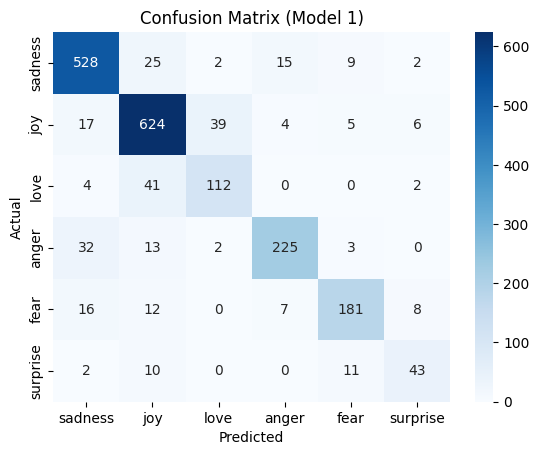

In [7]:
# Evaluating the Model and computing the classification report and confusion matrix.

X_testing_tfidf = tfidf_vectorizer.transform(X_testing)

y_output_svm_1 = svm_model.predict(X_testing_tfidf)

print("SVM Classifier Without POS Tags :")
print(classification_report(y_testing, y_output_svm_1))
print(f"Accuracy of Model 1: {accuracy_score(y_testing, y_output_svm_1):.5f}")

# Confusion Matrix for Model 1
cm = confusion_matrix(y_testing, y_output_svm_1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['train'].features['label'].names, yticklabels=dataset['train'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Model 1)')
plt.show()

In [8]:
# TASK 3: Emotion Recognizer with POS Tags
# Implementing a pipeline and custom transformers to combine the POS tag features and the input text features
# Here concatenating the POS tags with the input text

class POS_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y = None):
        return self

    def transform(self, X):     # tagging the input text 
        pos_tagged_data = []
        for sentence in X:
            pos_tags = viterbi_alg(sentence.split(), unique_tags, transition_probs, emission_probs)     # Using the Viterbi algorithm implemented earlier
            pos_tagged_data.append(' '.join(pos_tags))
        return pos_tagged_data
    

class feature_transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y = None):
        concatenated_features = []
        for i in range(len(X)):
            concatenated_features.append(y[i] + ' ' + X[i])   # Concatenating the POS tags with the input text
        return concatenated_features
        

transform_pipeline = Pipeline([
    ('pos', POS_Transformer()),  # Adding POS tags to the input text
    ('concatenator', feature_transformer())     # Concatenating the POS tags with the input text
])

# Transforming the training, validation, and testing datasets
X_train_combined = transform_pipeline.fit_transform(X_training, y = X_training)
X_valid_combined = transform_pipeline.fit_transform(X_validation, y = X_validation)
X_test_combined = transform_pipeline.fit_transform(X_testing, y = X_testing)

print(f"Example of combined features: {X_train_combined[0]}")

Example of combined features: i didnt feel humiliated `` PRP VBP VBN


In [9]:
# Hyperparameter tuning for SVM model with POS tags
# Defining the parameter grid for GridSearchCV
parameter_grid_2 = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],          # Maximum number of features to consider
    'svm__C': [0.1, 1, 10, 100]                              # Regularization parameter
}

# # Creating a pipeline for TF-IDF and SVM model 2
pipeline_combined = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear'))                       # Using linear kernel for SVM here
])

# GridSearchCV to find the best hyperparameters
grid_search_combined = GridSearchCV(pipeline_combined, parameter_grid_2, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)    # Using 5-fold cross-validation and scoring based on accuracy

# Fit the grid search to the validation set for tuning
grid_search_combined.fit(X_valid_combined, y_validation)

# Print the best parameters and the corresponding score
print("Best Parameters (With POS Tags):", grid_search_combined.best_params_)
print("Best Validation Accuracy (With POS Tags):", grid_search_combined.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters (With POS Tags): {'svm__C': 10, 'tfidf__max_features': 5000}
Best Validation Accuracy (With POS Tags): 0.7015


In [10]:
# Training the SVM with POS tags

# Using the best hyperparameters obtained from GridSearchCV
best_max_features_combined = grid_search_combined.best_params_['tfidf__max_features']
best_C_combined = grid_search_combined.best_params_['svm__C']

# Creating the TF-IDF vectorizer with the best hyperparameters
tfidf_vectorizer_combined = TfidfVectorizer(max_features=best_max_features_combined)

# Fitting the vectorizer on the training data
X_train_combined_tfidf = tfidf_vectorizer_combined.fit_transform(X_train_combined)

# Training the SVM model with the best hyperparameters
svm_model_combined = SVC(C=best_C_combined, kernel='linear')
svm_model_combined.fit(X_train_combined_tfidf, y_training)

print("SVM model with POS tags: Training completed")

SVM model with POS tags: Training completed


SVM Classifier With POS Tags:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       581
           1       0.87      0.90      0.88       695
           2       0.74      0.72      0.73       159
           3       0.90      0.82      0.86       275
           4       0.87      0.81      0.84       224
           5       0.71      0.67      0.69        66

    accuracy                           0.86      2000
   macro avg       0.83      0.80      0.82      2000
weighted avg       0.86      0.86      0.86      2000

Accuracy of Model 2: 0.86050


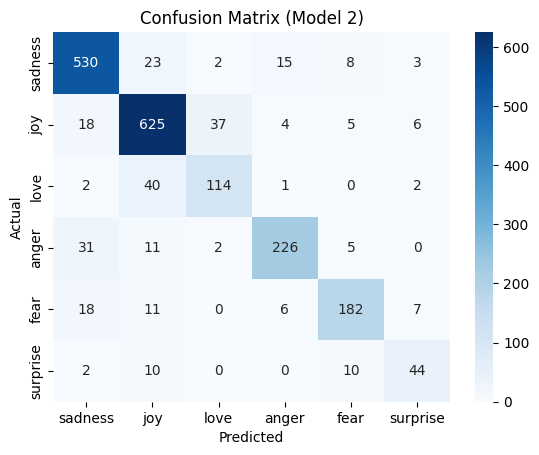

In [11]:
# Evaluate the Combined Feature Model and Display the classification report and confusion matrix.

X_testing_tfidf_combined = tfidf_vectorizer_combined.transform(X_test_combined)

y_output_svm_2 = svm_model_combined.predict(X_testing_tfidf_combined)

print("SVM Classifier With POS Tags:")
print(classification_report(y_testing, y_output_svm_2))
print(f"Accuracy of Model 2: {accuracy_score(y_testing, y_output_svm_2):.5f}")

# Confusion Matrix for Model 2
cm_combined = confusion_matrix(y_testing, y_output_svm_2)
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['train'].features['label'].names, yticklabels=dataset['train'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Model 2)')
plt.show()